# Alignment tutorial for two E15.5 Stereo-seq mouse embryo slices
In this tutorial, we will demonstrate how to implement two E15.5 mouse embryo slices alignment using 3d-OT and calculate the chamfer distance

## Loading package

In [1]:
from lib_3d_OT.utils import *
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from lib_3d_OT.single_modialty import *
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

During startup - Warning messages:
1: package ‘methods’ was built under R version 4.3.2 
2: package ‘datasets’ was built under R version 4.3.2 
3: package ‘utils’ was built under R version 4.3.2 
4: package ‘grDevices’ was built under R version 4.3.2 
5: package ‘graphics’ was built under R version 4.3.2 
6: package ‘stats’ was built under R version 4.3.2 
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



In [2]:
import os
os.environ['R_HOME'] = '/home/dbj/anaconda3/envs/r/lib/R'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## Loading and Pre-processing two E15.5 Stereo-seq slices 
+ First, we need to prepare the single cell spatial data into AnnData objects. AnnData is the standard data class we use in 3d-OT. 
+ See [documentation](https://anndata.readthedocs.io/en/latest/index.html) for more details if you are unfamiliar, including how to construct AnnData objects from scratch, and how to read data in other formats (csv, mtx, loom, etc.) into AnnData objects.
+ `dpca` is the preprocessing process for reference [SLAT](https://www.nature.com/articles/s41467-023-43105-5)

In [3]:
adata1=sc.read_h5ad('/home/dbj/mouse/oT/mouse/Chen-Stereo_seq-E15.5-s1.h5ad')
adata2=sc.read_h5ad('/home/dbj/mouse/oT/mouse/Chen-Stereo_seq-E15.5-s2.h5ad')
adata1.obs['truth']=adata1.obs['annotation']
adata2.obs['truth']=adata2.obs['annotation']
adatalist=[adata1,adata2]
adata1,adata2=dpca(adatalist,n_comps=50,join='inner')

## Constructing neighbor graph and training the Pointnet++Encoder
We first build the neighbor graph `graph1` of rep1 and train the encoder to get a trained encoder `best_model1`

In [4]:
set_seed(7)
graph1 = prepare_data(adata2, location="spatial", nb_neighbors=8).to(device)
input_dim1 = graph1.express.shape[-1]
model1 = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model1.parameters(), lr=0.001)
best_model1, min_loss = train_graph_extractor(graph1, model1, optimizer, device,epochs=800)

Epoch 800/800, Loss: 1.076702, Min Loss: 1.072592

## Constructing neighbor graph and training the Pointnet++Encoder
We then build the neighbor graph `graph2` of rep2 and train the encoder to get a trained encoder `best_model2`

In [5]:
set_seed(7)
graph2 = prepare_data(adata1, location="spatial", nb_neighbors=8).to(device)
input_dim2 = graph2.express.shape[-1]
model2 = extractMODEL(args=None, input_dim=input_dim2)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
best_model2,min_loss = train_graph_extractor(graph2, model2,optimizer2, device, epochs=800)

Epoch 800/800, Loss: 1.057312, Min Loss: 1.049954

## Training the optimal transport module
Enter graph1 and graph2 and the two encoders we trained into the optimal transport model

In [6]:
pclouds_list=[graph1,graph2]

In [24]:
set_seed(7)
input_dim1 = pclouds_list[0].express.shape[-1]
input_dim2 = pclouds_list[1].express.shape[-1]
model = UnifiedModel(input_dim1=input_dim1,input_dim2=input_dim2,simk=5,otk=300,reconk=1,best_encoder1=best_model1,best_encoder2=best_model2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
lr_lambda = lambda epoch: 1.0 if epoch < 340 else 1.0
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
args = {
    "backward_dist_weight":1.0,
    "use_smooth_flow":1,
    "smooth_flow_loss_weight":1.0,
    "use_div_flow":1,
    "div_flow_loss_weight":1.0,
    "div_neighbor": 8,
    "lattice_steps": 10,
    "nb_neigh_smooth_flow":32,
}



train(model=model,pcloud_list=pclouds_list,optimizer=optimizer,scheduler=scheduler,device=device,nb_epochs=1,use_corr_conf=False,use_smooth_flow=True,use_div_flow=True,args=args)

Time Pair 0,total_loss: 0.1472,smooth_flow_loss: 0.0912 Target Recon Loss: 0.00004472,Div Flow Loss: 0.0559

## Source alignment slice

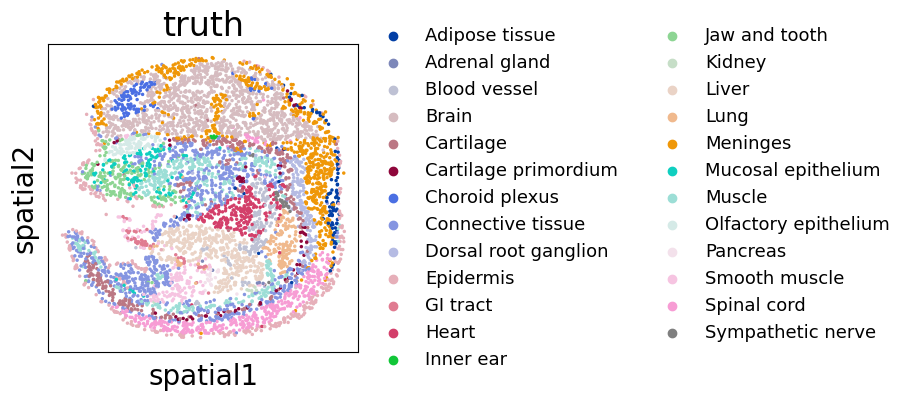

In [8]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20
adata1_rotated = copy.deepcopy(adata1)
coords = adata1_rotated.obsm['spatial']

adata1_rotated.obsm['spatial'] = np.column_stack((coords[:, 0],-coords[:, 1]))
fig, ax = plt.subplots()
sc.pl.embedding(adata1_rotated,basis='spatial',color='truth',size=25,ax=ax,legend_fontsize=13)

## Target alignment slice

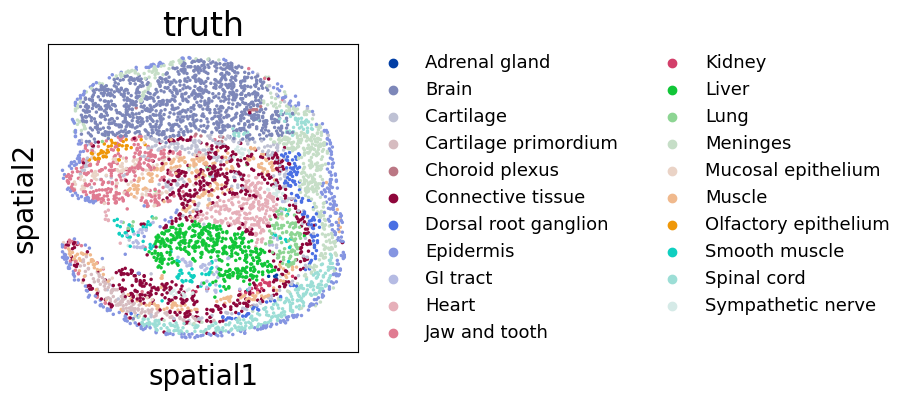

In [9]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20
adata2_rotated = copy.deepcopy(adata2)
coords = adata2_rotated.obsm['spatial']

adata2_rotated.obsm['spatial'] = np.column_stack((coords[:, 0],-coords[:, 1]))
fig, ax = plt.subplots()
sc.pl.embedding(adata2_rotated,basis='spatial',color='truth',size=25,ax=ax,legend_fontsize=13)

## Visualize and quantify the evaluation of seven region alignment results
+ `selected_cell_type` represents the drawn source cell type
+ `finaltruth` means that the target cell type corresponding to the source cell type that based on the biological understanding, and it is used to obtain the spatial location information of the target cell type and calculate the chamfer distance
+ `all_arrow_ends` represents all aligned flow end positions from source cell type,it is used to calculate the chamfer distance
+ `layer_1_pcloud_3D`represents the target cell type spatial position information based on biological understanding, and is used to calculate the chamfer distance

Number of arrow ends: 1052
Layer 1 points count: 1063


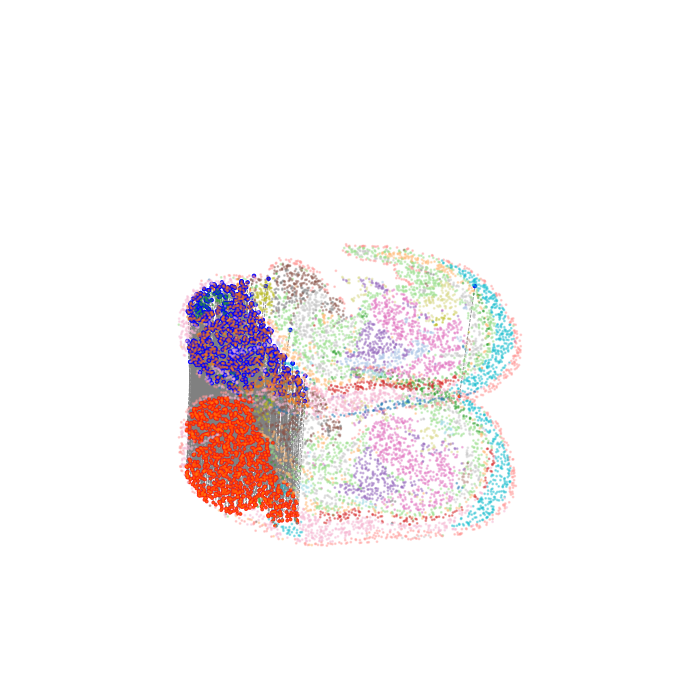

In [25]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Brain',finaltruth=['Brain'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=1,alpha=0.4,
    #save_path='/home/dbj/DPLFC/'
)

`-Log10(chamfer_distance)` as a performance metric for alignment

In [26]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.0005559758255398436


Number of arrow ends: 382
Layer 1 points count: 350


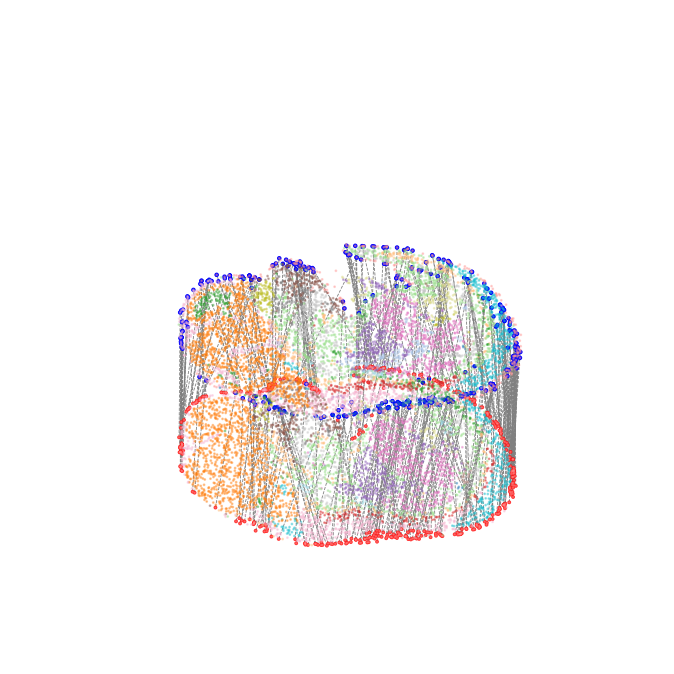

In [27]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Epidermis',finaltruth=['Epidermis'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=1,alpha=0.4,
    #save_path='/home/dbj/DPLFC/'
)

In [28]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.0035619710656050936


Number of arrow ends: 214
Layer 1 points count: 222


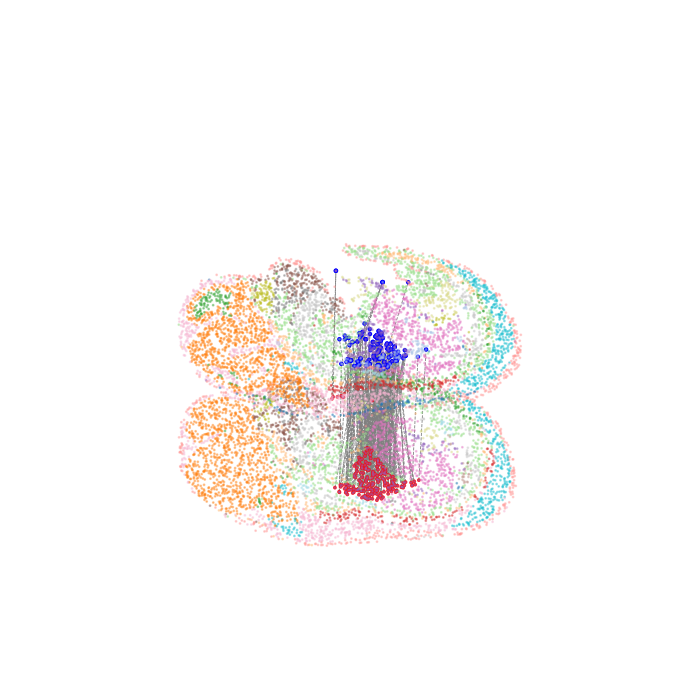

In [29]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Heart',finaltruth=['Heart'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=1,alpha=0.4,
    #save_path='/home/dbj/DPLFC/'
)

In [30]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.0037783370197349017


Number of arrow ends: 290
Layer 1 points count: 376


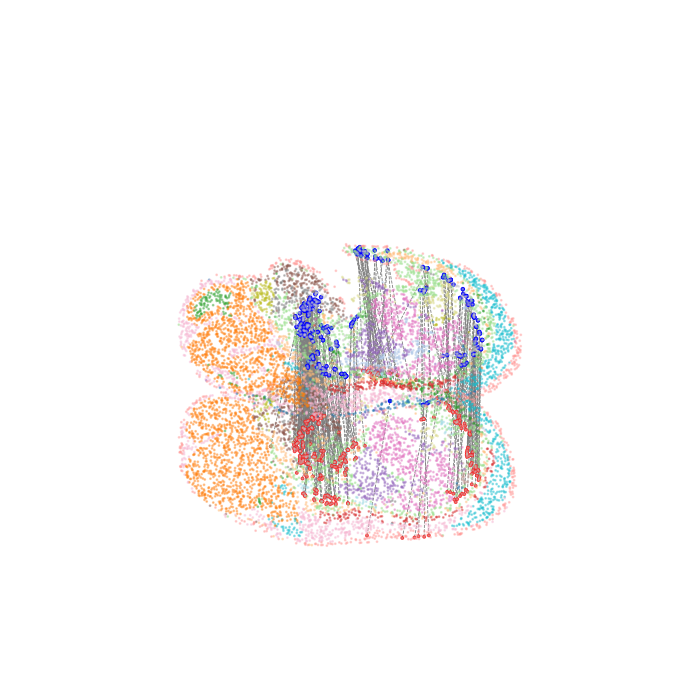

In [31]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Muscle',finaltruth=['Muscle'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=1,alpha=0.4,
    #save_path='/home/dbj/DPLFC/'
)

In [32]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.00018840872474427232


Number of arrow ends: 302
Layer 1 points count: 371


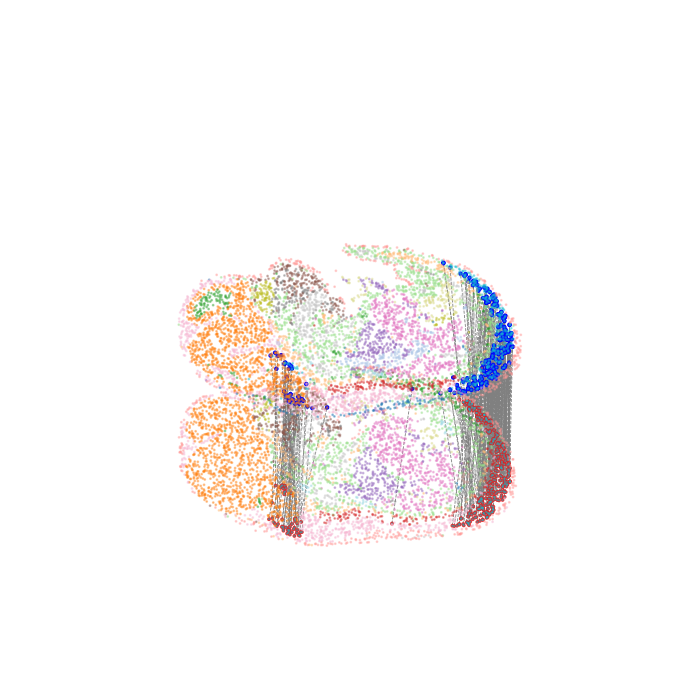

In [33]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Spinal cord',finaltruth=['Spinal cord'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=1,alpha=0.4,
    #save_path='/home/dbj/DPLFC/'
)

In [34]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.00034934705868540816


Number of arrow ends: 627
Layer 1 points count: 847


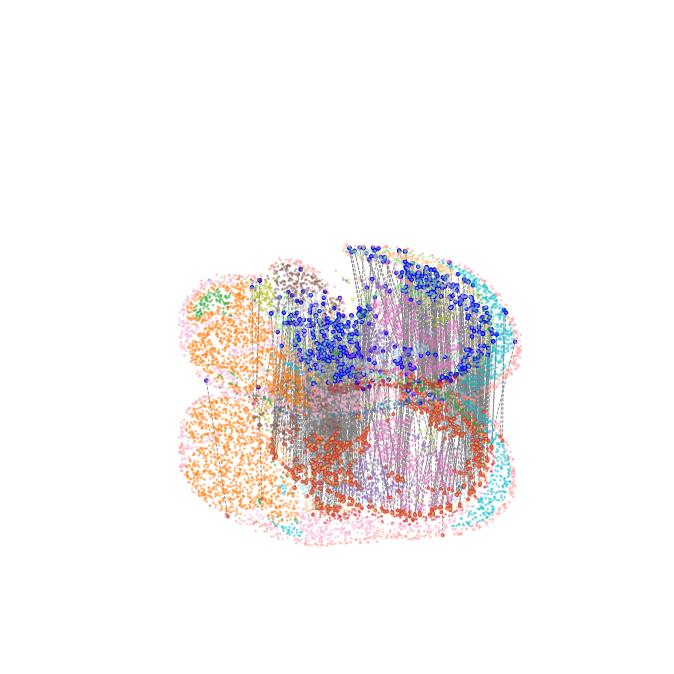

In [35]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Connective tissue',finaltruth=['Connective tissue'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=1,alpha=0.4,
    #save_path='/home/dbj/DPLFC/'
)

In [36]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.0008761489905992954


Number of arrow ends: 402
Layer 1 points count: 369


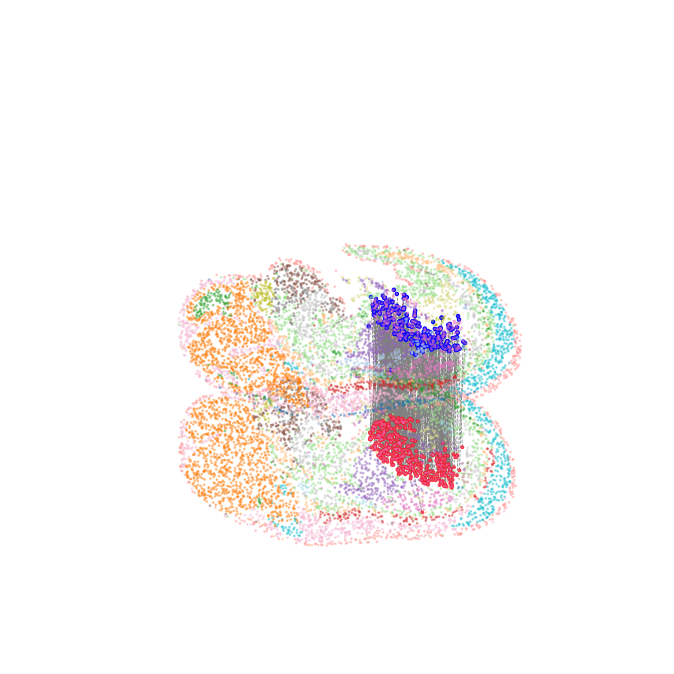

In [37]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Liver',finaltruth=['Liver'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=1,alpha=0.4,
    #save_path='/home/dbj/DPLFC/'
)

In [38]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.00015183553451676208
